In [ ]:
s3_bucket_folder_address = '' # contained the location of our data

In [1]:
import pandas as pd
import boto3 
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [25]:
def plotting(load_dict, set_ymax=None, locs=None, ax=None, xlab=True, ylab=True, ncol=1, fonts=18):

    colours = ['#bf812d', '#dfc27d', '#f6e8c3', '#80cdc1',  '#01665e', '#003c30']
    labels=['Residential L2', 'MUD L2', 'Workplace L2', 'Public L2', 'Public DCFC']

    if locs is None:
        locs = np.arange(0, 6)
    xax = True
    xplot = (1/60)*np.arange(0, 1440)
    
    axin = True
    if ax is None:
        axin = False
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    data = np.zeros((1440, 6))
    data[:, 1] = load_dict['Residential L2']
    data[:, 2] = load_dict['MUD L2']
    data[:, 3] = load_dict['Workplace L2']
    data[:, 4] = load_dict['Public L2']
    data[:, 5] = load_dict['Public DCFC']

    patterns = ['o', '/', '///', '\\', 'x', '.', '*']

    data = np.copy(data / 1000) #  MW
    base = np.zeros((1440, ))
    for i in range(np.shape(data)[1]):
        ax.plot(xplot, base+data[:, i], color=colours[i])
        if i > 0:
            ax.fill_between(xplot, base, base+data[:, i], hatch=patterns[i], facecolor=colours[i], label=labels[i-1], edgecolor='grey')
        base += data[:, i]
    ax.plot(xplot, base, 'k')
    ax.set_xlim([0, 24])
    if set_ymax is None:
        ax.set_ylim([0, 1.1*np.max(base)])
    else:
        ax.set_ylim([0, set_ymax])


    ax.set_xticks([0, 3, 6, 9, 12, 15, 18, 21])        
    if xlab:
        ax.set_xlabel('Time of day [h]', fontsize=fonts+2)
        ax.set_xticklabels([0, 3, 6, 9, 12, 15, 18, 21], fontsize=fonts+2)
    else:
        ax.set_xticklabels([])

    if ylab:
        ax.set_yticks(locs)
        ax.set_yticklabels(locs.astype(int), fontsize=fonts+2)
        ax.set_ylabel('Load [MW]', fontsize=fonts+2)
    
    ax.set_axisbelow(True)        
    ax.grid(alpha=0.7)
    
    ax.legend(loc='upper right', ncol=ncol, fontsize=fonts-1, framealpha=0.2)
    if axin:
        return ax
    else:
        plt.tight_layout()
        plt.show()

In [3]:
import os
os.chdir('..')
from speech import DataSetConfigurations
from speech import SPEECh
from speech import SPEEChGeneralConfiguration


# Load

In [4]:
df = pd.read_csv(s3_bucket_folder_address+'sessions2019.csv', index_col=0)
key_driver_info = pd.read_csv(s3_bucket_folder_address+'2019_unscaled_revised.csv', index_col=0)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
reorder_dendtoac = {0:11, 1:12, 2:5, 3:1, 4:13, 5:3, 6:8, 7:15, 8:2, 9:9, 10:7, 11:14, 12:4, 13:6, 14:10, 15:0}
reorder_actodend = {j: i for i, j in reorder_dendtoac.items()}
for i in range(16):
    inds = key_driver_info[key_driver_info['Agglom Cluster Number']==i].index
    key_driver_info.loc[inds, 'Dend Cluster Number'] = reorder_actodend[i]
key_driver_info['Dend Cluster Number'] = key_driver_info['Dend Cluster Number'].astype(int)

In [10]:
key_driver_info['Dend Cluster Number'].value_counts()

15    6612
0     6251
8     5885
2     4818
1     2776
14    2632
12    2148
10    1753
11     981
7      848
13     839
6      801
3      758
5      632
4      460
9       71
Name: Dend Cluster Number, dtype: int64

In [11]:
key_driver_info['Dend Cluster Number'].value_counts().sum()

38265

### raw data profile

In [12]:
def raw_data_load(df_subset, num_ts=1440):
    
    all_loads = {}

    start_times = (1/60)*df_subset['start_seconds'].values.astype(int)
    energies = df_subset['Energy (kWh)'].values
    rates = df_subset['Max Power'].values

    end_times, load = end_times_and_load_mixedrates(start_times, energies, rates, 60, 1440)
    all_loads['total'] = load
    
    wp_set = df_subset[df_subset['POI Category']=='Workplace']
    res_set = df_subset[df_subset['POI Category']=='Single family residential']
    mud_set = df_subset[df_subset['POI Category']=='Mul tifamily Home Service']
    other_set = df_subset[df_subset['POI Category'].isin(['Education', 'Utility', 'Retail', 'Parking', 'Healthcare', 'Municipal', 'Multifamily Commercial', 'Parks and Recreation', 'Hospitality', 'Government (Fed, State)'])]
    other_slow_set = other_set[other_set['Max Power']<20]
    other_fast_set = other_set[other_set['Max Power']>=20]
    labels = ['Residential L2', 'Workplace L2', 'MUD L2', 'Public L2', 'Public DCFC']
    
    for i, data in enumerate([res_set, wp_set, mud_set, other_slow_set, other_fast_set]):
        start_times = (1/60)*data['start_seconds'].values.astype(int)
        energies = data['Energy (kWh)'].values
        rates = data['Max Power'].values

        end_times, load = end_times_and_load_mixedrates(start_times, energies, rates, 60, 1440)
        all_loads[labels[i]] = load
        
    return all_loads

In [13]:
def end_times_and_load_mixedrates(start_times, energies, rate, time_steps_per_hour, num_time_steps):

    num = np.shape(start_times)[0]
    load = np.zeros((num_time_steps,))
    end_times = np.zeros(np.shape(start_times)).astype(int)

    lengths = (time_steps_per_hour * energies / rate).astype(int)
    extra_charges = energies - lengths * rate / time_steps_per_hour
    inds1 = np.where((start_times + lengths) > num_time_steps)[0]
    inds2 = np.delete(np.arange(0, np.shape(end_times)[0]), inds1)

    end_times[inds1] = (np.minimum(start_times[inds1].astype(int)+lengths[inds1]-num_time_steps, num_time_steps)).astype(int)
    end_times[inds2] = (start_times[inds2] + lengths[inds2]).astype(int)
    inds3 = np.where(end_times >= num_time_steps)[0]
    inds4 = np.delete(np.arange(0, np.shape(end_times)[0]), inds3)

    for i in range(len(inds1)):
        idx = int(inds1[i])
        load[np.arange(int(start_times[idx]), num_time_steps)] += rate[idx] * np.ones((num_time_steps - int(start_times[idx]),))
        load[np.arange(0, end_times[idx])] += rate[idx] * np.ones((end_times[idx],))
    for i in range(len(inds2)):
        idx = int(inds2[i])
        load[np.arange(int(start_times[idx]), end_times[idx])] += rate[idx] * np.ones((lengths[idx],))
    load[0] += np.sum(extra_charges[inds3] * time_steps_per_hour)
    for i in range(len(inds4)):
        load[end_times[int(inds4[i])]] += extra_charges[int(inds4[i])] * time_steps_per_hour

    return end_times, load

In [14]:
# # 1, 2 is good, 6 is good, 10 is good, 13 is good
# drivers = key_driver_info[key_driver_info['Dend Cluster Number']==15]['Unique Driver ID'].values
# subset = df[df['Driver ID'].isin(drivers)]

# print(np.unique(subset[subset['start_day']==51]['Driver ID']).shape)
# print(subset[subset['start_day']==51]['start_datetime'].values[0])
# print(subset[subset['start_day']==51]['start_weekday'].values[0])
# print(len(drivers))
# all_loads = raw_data_load(subset[subset['start_day']==51])
# # total_all_loads = raw_data_load(df.loc[(df['start_day']==51)&(df['Driver ID'].isin(key_driver_info['Unique Driver ID'].values))])
# plotting(all_loads, set_ymax=40, locs=np.arange(0, 40, 10))

### simulated profile

In [15]:
def simulated_load(num_drivers, dend_cluster, weekday_option='weekday', return_drivers=False):#indicator=True, weekday='weekdays', return_drivers=False):
    total_evs = num_drivers
    data = DataSetConfigurations('Original16', ng=16)
    model = SPEECh(data)
    config = SPEEChGeneralConfiguration(model)
    config.change_pg(new_weights={reorder_dendtoac[dend_cluster]: 1})
    config.num_evs(total_evs)
    config.groups()
    config.run_all(verbose=False, weekday=weekday_option)
    return config.total_load_dict

def simulated_load_all(num_drivers, weekday_option='weekday'):
    
    total_evs = num_drivers
    data = DataSetConfigurations('Original16', ng=16)
    model = SPEECh(data)
    config = SPEEChGeneralConfiguration(model)
    config.num_evs(total_evs)
    config.groups()
    config.run_all(verbose=False, weekday=weekday_option)

    return config.total_load_dict

In [16]:
num_drivers = len(np.unique(df[df['Driver ID'].isin(key_driver_info['Unique Driver ID'].values)]['Driver ID']))
print(num_drivers) #38265

38265


In [20]:
drivers = key_driver_info['Unique Driver ID'].values
subset = df[df['Driver ID'].isin(drivers)]
# exclude sessions from drivers not used in the study

In [22]:
# simulate results for each 

results_sim_weekday = simulated_load_all(num_drivers, weekday_option='weekday')
results_sim_weekend = simulated_load_all(num_drivers, weekday_option='weekend')

results_true = {}
ma_error = {}
rmse_error = {}
rmse_error_relative = {}
weekday = {}

for day in np.arange(1, 366):
    weekday_option='weekday'
    if len(subset[subset['start_day']==day]) > 0:
        if subset[subset['start_day']==day]['start_weekday'].values[0] in [5, 6]:
            weekday_option = 'weekend'
        weekday[day-1] = subset[subset['start_day']==day]['start_weekday'].values[0]
        total_all_loads = raw_data_load(df.loc[(df['start_day']==day)&(df['Driver ID'].isin(key_driver_info['Unique Driver ID'].values))])
        results_true[day-1] = total_all_loads
        if weekday_option == 'weekday':
            ma_error[day-1] = np.mean(np.abs((total_all_loads['total'] - pd.DataFrame(results_sim_weekday).sum(axis=1))))
            rmse_error[day-1] = np.sqrt(np.mean(np.power((total_all_loads['total'] - pd.DataFrame(results_sim_weekday).sum(axis=1)), 2)))
            rmse_error_relative[day-1] = np.sqrt(np.mean(np.power((total_all_loads['total'] - pd.DataFrame(results_sim_weekday).sum(axis=1)), 2))) / np.max(total_all_loads['total'])
        else:
            ma_error[day-1] = np.mean(np.abs((total_all_loads['total'] - pd.DataFrame(results_sim_weekend).sum(axis=1))))
            rmse_error[day-1] = np.sqrt(np.mean(np.power((total_all_loads['total'] - pd.DataFrame(results_sim_weekend).sum(axis=1)), 2)))
            rmse_error_relative[day-1] = np.sqrt(np.mean(np.power((total_all_loads['total'] - pd.DataFrame(results_sim_weekend).sum(axis=1)), 2))) / np.max(total_all_loads['total'])
            
            

In [29]:
# weekday 
results_mean = pd.DataFrame(results_true[0])
ct = 1
for key in results_true.keys():
    if key != 0:
        if weekday[key] in [0,1,2,3,4]:
            test = pd.DataFrame(results_true[key])
            for col in test.columns:
                results_mean[col] += test[col].values
            ct += 1
results_mean = results_mean / ct

In [30]:
# weekend
results_mean2 = pd.DataFrame(results_true[0])
ct = 1
for key in results_true.keys():
    if key != 0:
        if weekday[key] in [5,6]:
            test = pd.DataFrame(results_true[key])
            for col in test.columns:
                results_mean2[col] += test[col].values
            ct += 1
results_mean2 = results_mean2 / ct

In [36]:
print('Weekday RMSE [kW]: ', np.round(np.sqrt(np.mean(np.power((results_mean['total'] - pd.DataFrame(results_sim_weekday).sum(axis=1)), 2))), 2))
print('Weekday RMSE percent: ', np.round(np.sqrt(np.mean(np.power((results_mean['total'] - pd.DataFrame(results_sim_weekday).sum(axis=1)), 2))) / np.max(results_mean['total']), 4))
print('Weekend RMSE [kW]: ', np.round(np.sqrt(np.mean(np.power((results_mean2['total'] - pd.DataFrame(results_sim_weekend).sum(axis=1)), 2))), 2))
print('Weekend RMSE percent: ', np.round(np.sqrt(np.mean(np.power((results_mean2['total'] - pd.DataFrame(results_sim_weekend).sum(axis=1)), 2))) / np.max(results_mean2['total']), 4))


Weekday RMSE [kW]:  1519.93
Weekday RMSE percent:  0.0572
Weekend RMSE [kW]:  306.17
Weekend RMSE percent:  0.1156


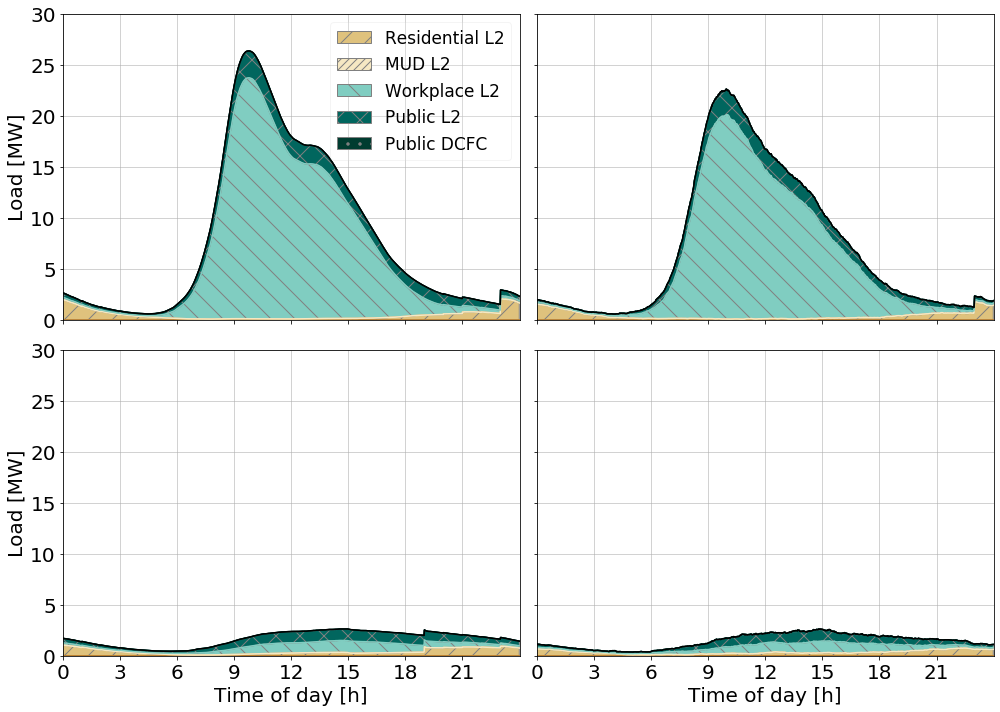

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
# fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
axes[0, 0] = plotting(results_mean, set_ymax=30, xlab=False, locs=np.arange(0, 35, 5), ax=axes[0, 0], ncol=1)
axes[0, 1] = plotting(results_sim_weekday, set_ymax=30, xlab=False, locs=np.arange(0, 35, 5), ax=axes[0, 1], ylab=False)
axes[0, 1].get_legend().remove()
axes[1, 0] = plotting(results_mean2, set_ymax=30, locs=np.arange(0, 35, 5), ax=axes[1, 0], ncol=1)
axes[1, 1] = plotting(results_sim_weekend, set_ymax=30, locs=np.arange(0, 35, 5), ax=axes[1, 1], ylab=False)
axes[1, 1].get_legend().remove()
axes[1, 0].get_legend().remove()
# axes[1].set_ylabel('')
plt.tight_layout()
plt.savefig('Figure5_validation_averageday_v2.pdf', bbox_inches='tight')
plt.show()


# Plots

In [48]:
## comparison
totalnum = 1e4

dend_clustnum = 3
drivers = key_driver_info[key_driver_info['Dend Cluster Number']==dend_clustnum]['Unique Driver ID'].values
subset = df[df['Driver ID'].isin(drivers)]
df_subset_res = subset.loc[(subset['POI Category']=='Single family residential')&(subset['start_weekday'].isin([0, 1, 2, 3, 4]))].copy(deep=True)

start_times_all = (1/60)*df_subset_res['start_seconds'].values.astype(int)
energies_all = df_subset_res['Energy (kWh)'].values
rates_all = df_subset_res['Max Power'].values

inds = np.random.choice(np.arange(0, len(df_subset_res)), int(totalnum), replace=True)
start_times = start_times_all[inds]
energies = energies_all[inds]
rates = rates_all[inds]

end_times, load = end_times_and_load_mixedrates(start_times, energies, rates, 60, 1440)
# end_times, load = end_times_and_load(start_times, energies, 6.6, 60, 1440)
np.save('Validation_Outputs_dend3_1e4_res_load.npy', load)

In [49]:
## comparison
totalnum = 1e4

dend_clustnum = 3
drivers = key_driver_info[key_driver_info['Dend Cluster Number']==dend_clustnum]['Unique Driver ID'].values
subset = df[df['Driver ID'].isin(drivers)]
df_subset_work = subset.loc[(subset['POI Category']=='Workplace')&(subset['start_weekday'].isin([0, 1, 2, 3, 4]))].copy(deep=True)

start_times_all = (1/60)*df_subset_work['start_seconds'].values.astype(int)
energies_all = df_subset_work['Energy (kWh)'].values
rates_all = df_subset_work['Max Power'].values

inds = np.random.choice(np.arange(0, len(df_subset_work)), int(totalnum), replace=True)
start_times = start_times_all[inds]
energies = energies_all[inds]
rates = rates_all[inds]

end_times, load = end_times_and_load_mixedrates(start_times, energies, rates, 60, 1440)
np.save('Validation_Outputs_dend3_1e4_work_load.npy', load)

In [43]:
import matplotlib.gridspec as gridspec

In [61]:
def loads_subsets(joint_gmm, num_vehicles, rate, num_ts=1440):
    
    sample_output_full = joint_gmm.sample(num_vehicles)
    sample_output = sample_output_full[0]
    
    all_loads = {}
    
    sample_output = sample_output[np.random.choice(np.shape(sample_output)[0], np.shape(sample_output)[0], replace=False), :]

    start_times = ((1/60) * np.mod(sample_output[:, 0], 24 * 3600)).astype(int)
    energies = np.clip(np.abs(sample_output[:, 1]), 0, 100)

    end_times, load = end_times_and_load(start_times, energies, rate, 60, 1440)
    all_loads['total'] = load
    for i in range(joint_gmm.n_components):
        subset = np.copy(sample_output_full[0][np.where(sample_output_full[1]==i)])
        subset = subset[np.random.choice(np.shape(subset)[0], np.shape(subset)[0], replace=False), :]

        start_times = ((1/60) * np.mod(subset[:, 0], 24 * 3600)).astype(int)
        energies = np.clip(np.abs(subset[:, 1]), 0, 100)

        end_times, load = end_times_and_load(start_times, energies, rate, 60, 1440)
        all_loads['subset_'+str(i)] = load
        

    return all_loads


In [63]:
def end_times_and_load(start_times, energies, rate, time_steps_per_hour, num_time_steps):

    num = np.shape(start_times)[0]
    load = np.zeros((num_time_steps,))
    end_times = np.zeros(np.shape(start_times)).astype(int)

    lengths = (time_steps_per_hour * energies / rate).astype(int)
    extra_charges = energies - lengths * rate / time_steps_per_hour
    inds1 = np.where((start_times + lengths) > num_time_steps)[0]
    inds2 = np.delete(np.arange(0, np.shape(end_times)[0]), inds1)

    end_times[inds1] = (np.minimum(start_times[inds1].astype(int)+lengths[inds1]-num_time_steps, num_time_steps)).astype(int)
    end_times[inds2] = (start_times[inds2] + lengths[inds2]).astype(int)
    inds3 = np.where(end_times >= num_time_steps)[0]
    inds4 = np.delete(np.arange(0, np.shape(end_times)[0]), inds3)

    for i in range(len(inds1)):
        idx = int(inds1[i])
        load[np.arange(int(start_times[idx]), num_time_steps)] += rate * np.ones((num_time_steps - int(start_times[idx]),))
        load[np.arange(0, end_times[idx])] += rate * np.ones((end_times[idx],))
    for i in range(len(inds2)):
        idx = int(inds2[i])
        load[np.arange(int(start_times[idx]), end_times[idx])] += rate * np.ones((lengths[idx],))
    load[0] += np.sum(extra_charges[inds3] * time_steps_per_hour)
    for i in range(len(inds4)):
        load[end_times[int(inds4[i])]] += extra_charges[int(inds4[i])] * time_steps_per_hour

    return end_times, load


In [116]:
def plotting2(data, segment_number, validation=None, set_ymax=None, locs=None, ax=None, xlab=True, ylab=True, ncol=1, fonts=18, smallxlab=False, legend=False):

    colours = ['#bf812d', '#dfc27d', '#f6e8c3', '#80cdc1',  '#01665e', '#003c30']
    labels=['Residential L2', 'MUD L2', 'Workplace L2', 'Public L2', 'Public DCFC']
    xplot = (1/60)*np.arange(0, 1440)
    patterns = ['o', '/', '///', '\\', 'x', '.', '*']

    
    data = np.copy(data / 1000) #  MW
    base = np.zeros((1440, ))
    ax.fill_between(xplot, 0, data, hatch=patterns[segment_number], facecolor=colours[segment_number], label=labels[segment_number-1], edgecolor='grey')
    if validation is not None:
        ax.plot((1/60)*np.arange(0, 1440), validation/1000, '--k', label='Data Sample')
    ax.plot(xplot, base+data, 'k', label='Simulated')
    ax.set_xlim([0, 24])
    
    
    if set_ymax is None:
        ax.set_ylim([0, 1.1*np.max(base)])
    else:
        ax.set_ylim([0, set_ymax])

    if xlab:            
        ax.set_xticks([0, 3, 6, 9, 12, 15, 18, 21])        
        ax.set_xlabel('Time of day [h]', fontsize=fonts+2)
        ax.set_xticklabels([0, 3, 6, 9, 12, 15, 18, 21], fontsize=fonts+2)
    elif smallxlab:
        ax.set_xticks([0, 6, 12, 18])        
        ax.set_xlabel('Time of day [h]', fontsize=fonts)
        ax.set_xticklabels([0, 6, 12, 18], fontsize=fonts)
    else:
        ax.set_xticklabels([])

    if ylab:
        ax.set_yticks(locs)
        ax.set_yticklabels(locs.astype(int), fontsize=fonts+2)
        ax.set_ylabel('Load [MW]', fontsize=fonts+2)
    else:
        ax.set_yticks(locs)
        ax.set_yticklabels([])
    
    ax.set_axisbelow(True)        
    ax.grid(alpha=0.7)
    
    if legend:
        ax.legend(loc='upper left', ncol=ncol, fontsize=fonts, framealpha=0.2)
    return ax
#     else:
#         plt.tight_layout()
#         plt.show()

In [119]:
val_load = np.load('Validation_Outputs_dend3_1e4_work_load.npy')
joint_gmm = pickle.load(open('Data/Original16/GMMs/weekday_work_'+str(reorder_dendtoac[3])+'.p', "rb"))
joint_gmm.weights_

array([0.13517831, 0.19795617, 0.14361195, 0.12627651, 0.15438811,
       0.13155455, 0.00915867, 0.10187573])

In [121]:
whichcomps = np.argsort(-joint_gmm.weights_)[0:4]
whichcomps

array([1, 4, 2, 0])

In [123]:
np.round(joint_gmm.weights_[whichcomps],2)

array([0.2 , 0.15, 0.14, 0.14])

Title 0: Weight = 0.2
Title 1: Weight = 0.15
Title 2: Weight = 0.14
Title 3: Weight = 0.14


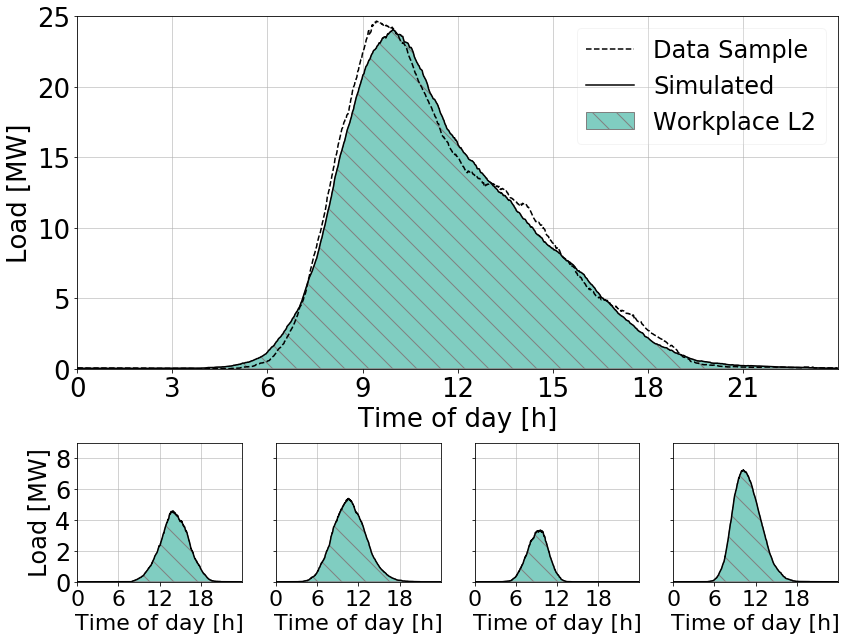

In [112]:
segnumber = 3

val_load = np.load('Validation_Outputs_dend3_1e4_work_load.npy')
joint_gmm = pickle.load(open('Data/Original16/GMMs/weekday_work_'+str(reorder_dendtoac[3])+'.p', "rb"))
all_loads = loads_subsets(joint_gmm, 1e4, 6.6)

fig = plt.figure(figsize=(12,9))#, constrained_layout=True) 
spec = gridspec.GridSpec(ncols=4, nrows=3, figure=fig)
ax0 = fig.add_subplot(spec[0:2, :])
ax0 = plotting2(all_loads['total'], segnumber, validation=val_load, set_ymax=25, xlab=True, locs=np.arange(0, 30, 5), ax=ax0, ncol=1, fonts=24, legend=True)
# ax0 = plotting(all_loads['total'], segnumber, ax=ax0, set_scale=1e3, set_ymax=25)
# ax0.plot((1/60)*np.arange(0, 1440), val_load/1e3, 'k')
whichcomps = np.argsort(-joint_gmm.weights_)[0:4]


i=0
ax1 = fig.add_subplot(spec[2, i])
ax1 = plotting2(all_loads['subset_'+str(whichcomps[i])], segnumber, ax=ax1, locs=np.arange(0, 9, 2), set_ymax=9,  ylab=True, smallxlab=True, xlab=False, fonts=22)#, ax=ax1, returnax=True, show=False, set_scale=1e3, set_ymax=10, xticks=True, smallxticks=True)
print('Title '+str(i)+': Weight = '+str(np.round(joint_gmm.weights_[whichcomps[i]], 2)))
i=1
ax2 = fig.add_subplot(spec[2, i])
ax2 = plotting2(all_loads['subset_'+str(whichcomps[i])], segnumber, ax=ax2, locs=np.arange(0, 9, 2), set_ymax=9,  ylab=False, smallxlab=True, xlab=False, fonts=22)
print('Title '+str(i)+': Weight = '+str(np.round(joint_gmm.weights_[whichcomps[i]], 2)))
i=2
ax3 = fig.add_subplot(spec[2, i])
ax3 = plotting2(all_loads['subset_'+str(whichcomps[i])], segnumber, ax=ax3, locs=np.arange(0, 9, 2), set_ymax=9,  ylab=False, smallxlab=True, xlab=False, fonts=22)#, show=False, set_scale=1e3, set_ymax=10,  yticks=False, xticks=True, smallxticks=True)
print('Title '+str(i)+': Weight = '+str(np.round(joint_gmm.weights_[whichcomps[i]], 2)))
i=3
ax4 = fig.add_subplot(spec[2, i])
ax4 = plotting2(all_loads['subset_'+str(whichcomps[i])], segnumber, ax=ax4, locs=np.arange(0, 9, 2), set_ymax=9,  ylab=False, smallxlab=True, xlab=False, fonts=22)#, show=False, set_scale=1e3, set_ymax=10,  yticks=False, xticks=True, smallxticks=True)
print('Title '+str(i)+': Weight = '+str(np.round(joint_gmm.weights_[whichcomps[i]], 2)))


plt.tight_layout()
plt.savefig('Figure4_parta.pdf', bbox_inches='tight')
plt.show()

In [124]:
joint_gmm = pickle.load(open('Data/Original16/GMMs/weekday_home_'+str(reorder_dendtoac[3])+'.p', "rb"))
# joint_gmm.weights_
np.round(joint_gmm.weights_[whichcomps],2)

array([0.11, 0.15, 0.41, 0.27])

In [125]:
joint_gmm.weights_

array([0.27438057, 0.1132671 , 0.40824126, 0.05682862, 0.14728245])

Title 0: Weight = 0.41
Title 1: Weight = 0.27
Title 2: Weight = 0.15
Title 3: Weight = 0.11


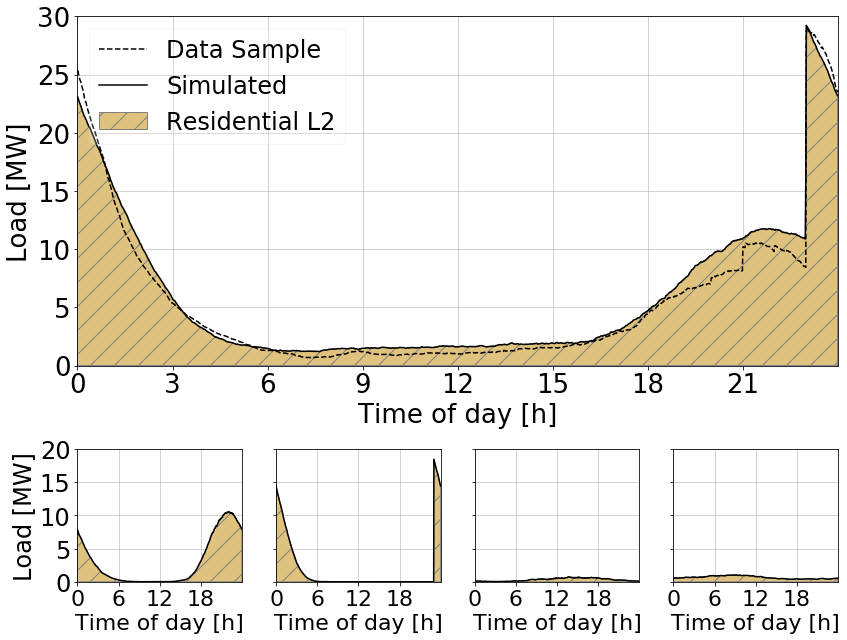

In [118]:
segnumber = 1

val_load = np.load('Validation_Outputs_dend3_1e4_res_load.npy')
joint_gmm = pickle.load(open('Data/Original16/GMMs/weekday_home_'+str(reorder_dendtoac[3])+'.p', "rb"))
all_loads = loads_subsets(joint_gmm, 1e4, 6.6)

fig = plt.figure(figsize=(12,9))#, constrained_layout=True) 
spec = gridspec.GridSpec(ncols=4, nrows=3, figure=fig)
ax0 = fig.add_subplot(spec[0:2, :])
ax0 = plotting2(all_loads['total'], segnumber, validation=val_load, set_ymax=25, xlab=True, locs=np.arange(0, 35, 5), ax=ax0, ncol=1, fonts=24, legend=True)
# ax0 = plotting(all_loads['total'], segnumber, ax=ax0, set_scale=1e3, set_ymax=25)
# ax0.plot((1/60)*np.arange(0, 1440), val_load/1e3, 'k')
whichcomps = np.argsort(-joint_gmm.weights_)[0:4]


i=0
ax1 = fig.add_subplot(spec[2, i])
ax1 = plotting2(all_loads['subset_'+str(whichcomps[i])], segnumber, ax=ax1, locs=np.arange(0, 25, 5), set_ymax=20,  ylab=True, smallxlab=True, xlab=False, fonts=22)#, ax=ax1, returnax=True, show=False, set_scale=1e3, set_ymax=10, xticks=True, smallxticks=True)
print('Title '+str(i)+': Weight = '+str(np.round(joint_gmm.weights_[whichcomps[i]], 2)))
i=1
ax2 = fig.add_subplot(spec[2, i])
ax2 = plotting2(all_loads['subset_'+str(whichcomps[i])], segnumber, ax=ax2, locs=np.arange(0, 25, 5), set_ymax=20,  ylab=False, smallxlab=True, xlab=False, fonts=22)
print('Title '+str(i)+': Weight = '+str(np.round(joint_gmm.weights_[whichcomps[i]], 2)))
i=2
ax3 = fig.add_subplot(spec[2, i])
ax3 = plotting2(all_loads['subset_'+str(whichcomps[i])], segnumber, ax=ax3, locs=np.arange(0, 25, 5), set_ymax=20,  ylab=False, smallxlab=True, xlab=False, fonts=22)#, show=False, set_scale=1e3, set_ymax=10,  yticks=False, xticks=True, smallxticks=True)
print('Title '+str(i)+': Weight = '+str(np.round(joint_gmm.weights_[whichcomps[i]], 2)))
i=3
ax4 = fig.add_subplot(spec[2, i])
ax4 = plotting2(all_loads['subset_'+str(whichcomps[i])], segnumber, ax=ax4, locs=np.arange(0, 25, 5), set_ymax=20,  ylab=False, smallxlab=True, xlab=False, fonts=22)#, show=False, set_scale=1e3, set_ymax=10,  yticks=False, xticks=True, smallxticks=True)
print('Title '+str(i)+': Weight = '+str(np.round(joint_gmm.weights_[whichcomps[i]], 2)))


plt.tight_layout()
plt.savefig('Figure4_partb.pdf', bbox_inches='tight')
plt.show()